# Personalized Search

**NOTE**: This notebook depends upon the the Retrotech dataset. If you have any issues, please rerun the [Setting up the Retrotech Dataset](../ch4/1.ch4-setting-up-the-retrotech-dataset.ipynb) notebook.

In [ ]:
from aips import *
from aips.spark import get_spark_session
import os
from IPython.display import display,HTML

spark = get_spark_session()

In [3]:
### Load product data
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType
products_collection = "products"    
product_update_opts={"zkhost": "aips-zk", "collection": products_collection}
spark.read.format("solr").options(**product_update_opts).load().createOrReplaceTempView("products")

# Collaborative Filtering with Implicit Preferences

In [4]:
def aggregate_signals(signals_collection, signals_aggregation_collection, signals_aggregation_query):

    create_collection(signals_aggregation_collection)

    print("Aggregating Signals to Create Signals Boosts...")
    signals_opts={"zkhost": "aips-zk", "collection": signals_collection}
    signals_boosting_opts={"zkhost": "aips-zk", "collection": signals_aggregation_collection, "gen_uniq_key": "true", "commit_within": "5000"}
    df = spark.read.format("solr").options(**signals_opts).load()
    df.registerTempTable("signals")


    spark.sql(signals_aggregation_query).write.format("solr").options(**signals_boosting_opts).mode("overwrite").save()
    print("Signals Aggregation Completed!")

In [17]:
#Weighting multiple signal types by user

signals_collection="signals"
signals_aggregation_collection="user_product_implicit_preferences"

mixed_signal_types_aggregation = """
select user, product, (
      (1 * click_boost) 
    + (0 * add_to_cart_boost) 
    + (0 * purchase_boost) ) as rating
from (
  select user, product, 
    sum(click) as click_boost,
    sum(add_to_cart) as add_to_cart_boost,
    sum(purchase) as purchase_boost
  from (  
      select cap.user, cap.target as product, 
        if(cap.type = 'click', 1, 0) as click, 
        if(cap.type = 'add-to-cart', 1, 0) as  add_to_cart, 
        if(cap.type = 'purchase', 1, 0) as purchase
      from signals cap 
      where (cap.type != 'query')
    ) raw_signals
  group by user, product
) as per_type_boosts
"""

aggregate_signals(signals_collection, signals_aggregation_collection, mixed_signal_types_aggregation)

Wiping 'user_product_implicit_preferences' collection
[('action', 'CREATE'), ('name', 'user_product_implicit_preferences'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'user_product_implicit_preferences' collection
Status: Success
Aggregating Signals to Create Signals Boosts...


/usr/local/spark/python/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


Signals Aggregation Completed!


In [18]:
user_prefs_options={"zkhost": "aips-zk", "collection": signals_aggregation_collection}
df = spark.read.format("solr").options(**user_prefs_options).load()
df.registerTempTable("user_product_implicit_preferences")

# !!!DELETE UNTIL NEXT NOTICE!!!

In [19]:
#product_dataframe=spark.sql("select user, product, boost from user_product_implicit_preferences")
#product_dataframe.createOrReplaceTempView("raw_user_item_prefs")


In [20]:
user_prefs = spark.sql("""select user, product, rating from user_product_implicit_preferences
                          where product in (
                              select product from (
                                  select product, count(user) user_count from user_product_implicit_preferences
                                  group by product
                                  limit 10000
                              ) top_products
                           )   
                       order by rating desc""")
#user_prefs.createOrReplaceTempView("top_product_user_prefs")
#spark.sql("""select count(*) from top_product_user_prefs""").show()


In [36]:
#book images example
from pyspark.ml.recommendation import ALS
import pandas 
import io
from pyspark.sql import Row
from pyspark.ml.evaluation import RegressionEvaluator


user_item_prefs = """
userIndex,productIndex,rating
0,0,9
0,1,7
0,3,1
0,4,7
1,0,2
1,2,9
1,3,10
1,5,10
2,0,9
2,1,6
2,2,3
2,3,4
2,4,8
2,5,1
3,0,10
3,1,7
3,2,6
3,3,8
3,4,1
3,5,9
4,0,1
4,1,3
4,2,9
4,4,1
4,5,7
"""

data = io.StringIO(user_item_prefs)
pd_df = pandas.read_csv(data, sep=",")
df = spark.createDataFrame(pd_df)
display(df)


als = ALS(maxIter=10, rank=3, regParam=0.10, implicitPrefs=False, userCol="userIndex", itemCol="productIndex", ratingCol="rating", coldStartStrategy="drop")

#prefsRDD = df.rdd.map(lambda p: Row(userIndex=int(p[0]), productIndex=int(p[1]),
#                                     boost=float(p[2])))

#prefsRDD.take(10)
#clean_user_prefs = spark.createDataFrame(prefsRDD)

clean_user_prefs = df

(training, test) = clean_user_prefs.randomSplit([0.8, 0.2])
#training.take(10)
#test.take(10)

print("Beginning model training")
model = als.fit(clean_user_prefs)

print("Beginning predictions")
predictions = model.transform(clean_user_prefs)

print("Beginning evaluation")
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


DataFrame[userIndex: bigint, productIndex: bigint, rating: bigint]

Beginning model training
Beginning predictions
Beginning evaluation
Root-mean-square error = 0.2831574136463788


In [53]:
#model.userFeatures.collect().foreach{case (productID,latentFactors) => println("proID:"+ productID + " factors:"+ latentFactors.mkString(",") )}
#model.productFeatures.collect().foreach{case (productID,latentFactors) => println("proID:"+ productID + " factors:"+ latentFactors.mkString(",") )}
import numpy
import pandas 
from pyspark.sql.functions import col

matrix_u = model.userFactors
print("users: ")
print(matrix_u.show(10,False))
matrix_i = model.itemFactors
print("items: ")
print(matrix_i.show(10,False))
#am = numpy.dot(matrix_u.rdd, matrix_i.rdd)
print("predictions: ")
print(predictions.orderBy(col("userIndex").asc(),col("prediction").desc()).show(100))

users: 
+---+-----------------------------------+
|id |features                           |
+---+-----------------------------------+
|0  |[-0.6238874, -0.9196519, 1.8258095]|
|1  |[1.3666669, 1.5634598, 0.6706434]  |
|2  |[0.33266556, -1.0720264, 1.8715069]|
|3  |[-0.42340577, 1.4799023, 1.9289703]|
|4  |[2.0163543, 0.39222753, 0.63329613]|
+---+-----------------------------------+

None
items: 
+---+------------------------------------+
|id |features                            |
+---+------------------------------------+
|0  |[-0.86946046, 0.043134067, 4.779752]|
|1  |[0.18344511, 0.12723537, 3.5788786] |
|2  |[3.238656, 2.0716133, 2.226322]     |
|3  |[2.7843966, 2.5188313, 2.8806121]   |
|4  |[0.14099391, -2.5484672, 2.6138852] |
|5  |[2.0812488, 3.5634575, 2.3043165]   |
+---+------------------------------------+

None
predictions: 
+---------+------------+------+----------+
|userIndex|productIndex|rating|prediction|
+---------+------------+------+----------+
|        0|          

In [25]:
import numpy

def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    '''
    R: rating matrix
    P: |U| * K (User features matrix)
    Q: |D| * K (Item features matrix)
    K: latent features
    steps: iterations
    alpha: learning rate
    beta: regularization parameter'''
    Q = Q.T

    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    # calculate error
                    eij = R[i][j] - numpy.dot(P[i,:],Q[:,j])

                    for k in range(K):
                        # calculate gradient with a and beta parameter
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])

        eR = numpy.dot(P,Q)

        e = 0

        for i in range(len(R)):

            for j in range(len(R[i])):

                if R[i][j] > 0:

                    e = e + pow(R[i][j] - numpy.dot(P[i,:],Q[:,j]), 2)

                    for k in range(K):

                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
        # 0.001: local minimum
        if e < 0.001:

            break

    return P, Q.T

In [42]:


R = [

     [9,7,-1,1,7,-1],

     [2,-1,9,10,-1,10],

     [9,6,3,4,8,1],

     [10,7,6,8,1,9],

     [1,3,9,-1,1,7]

    ]

R = numpy.array(R)
# N: num of User
N = len(R)
# M: num of Movie
M = len(R[0])
# Num of Features
K = 3

numpy.random.seed(0) #ONLY for reproducibility purposes for example. Comment out in production code.
P = numpy.random.rand(N,K)
Q = numpy.random.rand(M,K)

 

nP, nQ = matrix_factorization(R, P, Q, K)

nR = numpy.dot(nP, nQ.T)

In [43]:
print(P)
print(Q)
print(nR)

[[ 0.6739399  -0.51070211  2.81117838]
 [ 1.13126403  3.1778382  -0.1336868 ]
 [ 1.66397212 -0.07945968  2.50026981]
 [-0.04713731  2.76212533  2.28584453]
 [ 2.20404797  2.1608718  -0.20048418]]
[[ 0.09137152  0.7479391   3.43067962]
 [ 0.70582232  0.7495681   2.20931952]
 [ 1.91215473  2.17472719  0.01406682]
 [ 1.74290933  2.54408653  0.45622567]
 [ 1.80440229 -1.16920051  1.88968473]
 [ 0.28111633  3.0233993   0.29501458]]
[[ 9.32385721  6.30366709  0.21758395  1.15787754  7.12541272 -0.52526228]
 [ 2.02155816  2.88512067  9.07220245  9.99539463 -1.92690055  9.88645103]
 [ 8.67023335  6.63880312  3.04413988  3.83868752  7.82010108  0.96514744]
 [ 9.90359475  7.0872914   5.94888979  7.98779074  1.00499247  9.01211419]
 [ 1.12979073  2.7324532   8.91096721  9.24743456  1.07164489  7.0936264 ]]


# !!! Stop Deleting !!!

In [54]:
import datetime
print ("Start Time: " + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Start Time: 2023-09-11 14:50:44


In [55]:
##50K = all products
#This will take long time. Recommend setting to 1,000 if trying to just run through code
#without considering all products

top_product_count_for_recs = 50000 #all products. 

user_item_ratings = spark.sql(f"""
  select user, product, rating from user_product_implicit_preferences
  where product in (
    select product from (
      select product, count(user) user_count from user_product_implicit_preferences
      group by product
      limit {top_product_count_for_recs}
    ) top_products
  )   
  order by rating desc""")

In [56]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import IndexToString

userIndexer = StringIndexer(inputCol="user", outputCol="userIndex").fit(user_item_ratings)
productIndexer = StringIndexer(inputCol="product", outputCol="productIndex").fit(user_item_ratings)

def stringsToIndexes(user_item_ratings,user_indexer,product_indexer):
    #Fits a model to the input dataset with optional parameters.
    return product_indexer.transform(user_indexer.transform(user_item_ratings))
    
def indexesToStrings(user_item_ratings,user_indexer,product_indexer):
    userIndexToString = IndexToString(inputCol="userIndex", outputCol="user",
                                    labels=user_indexer.labels)
    
    productIndexToString = IndexToString(inputCol="productIndex", outputCol="product",
                                    labels=product_indexer.labels)

    return userIndexToString.transform(productIndexToString.transform(user_item_ratings))

In [63]:
indexedUserPrefs = stringsToIndexes(user_item_ratings,userIndexer,productIndexer)
indexedUserPrefs.orderBy(col("userIndex").asc(),col("rating").desc()).show(10)

+-------+------------+------+---------+------------+
|   user|     product|rating|userIndex|productIndex|
+-------+------------+------+---------+------------+
|u159789|024543718710|     1|      0.0|       263.0|
|u159789|018713571687|     1|      0.0|     10355.0|
|u159789|008888345435|     1|      0.0|      5073.0|
|u159789|813985010007|     1|      0.0|      5819.0|
|u159789|801213001996|     1|      0.0|     28736.0|
|u159789|886541105851|     1|      0.0|      1394.0|
|u159789|886112115302|     1|      0.0|       548.0|
|u159789|720616236029|     1|      0.0|      2781.0|
|u159789|025192979620|     1|      0.0|     12289.0|
|u159789|025193102324|     1|      0.0|      9650.0|
+-------+------------+------+---------+------------+
only showing top 10 rows



In [58]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

als = ALS(maxIter=3, rank=10, regParam=0.15, implicitPrefs=True, userCol="userIndex", itemCol="productIndex", ratingCol="rating", coldStartStrategy="drop")

(training, test) = indexedUserPrefs.randomSplit([0.8, 0.2])

print("Beginning model training")
model = als.fit(indexedUserPrefs)

print("Beginning predictions")
predictions = model.transform(test)

print("Beginning evaluation")
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Beginning model training
Beginning predictions
Beginning evaluation
Root-mean-square error = 0.9597145645338756


In [62]:
# Generate top 3 product recommendations for each user
indexedUserRecs = model.recommendForAllUsers(10)
indexedUserRecs.show(10)


print(predictions.orderBy(col("userIndex").asc(),col("prediction").desc()))

+---------+--------------------+
|userIndex|     recommendations|
+---------+--------------------+
|       26|[{3, 0.07131122},...|
|       27|[{9, 0.006997348}...|
|       28|[{11, 0.10574821}...|
|       31|[{7, 0.017309517}...|
|       34|[{9, 0.00690294},...|
|       44|[{3, 0.03240246},...|
|       53|[{13, 0.023354078...|
|       65|[{7, 0.035253286}...|
|       76|[{1, 0.020188266}...|
|       78|[{16, 0.03562626}...|
+---------+--------------------+
only showing top 10 rows

DataFrame[user: string, product: string, rating: bigint, userIndex: double, productIndex: double, prediction: float]


In [60]:
from pyspark.sql.functions import explode, col

exploded = (indexedUserRecs.select("userIndex", explode("recommendations").alias("productIndex_rating"))).select("userIndex", col("productIndex_rating.*"))
userItemRecs = indexesToStrings(exploded,userIndexer,productIndexer).select("user", "product", col("prediction").alias("boost"))

In [25]:
print ("Start Time: " + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

#Write recommendations to Solr
def write_boosts_signals(recommendations_collection, userItemRecs):

    create_collection(recommendations_collection)

    print("Writing recommendations to Solr...")
    signals_opts={"zkhost": "aips-zk", "collection": recommendations_collection}
    opts={"zkhost": "aips-zk", "collection": recommendations_collection, "gen_uniq_key": "true", "commit_within": "5000"}
    userItemRecs.registerTempTable("temp_user_item_recs") #faster to use spark.sql than write df directly due to execution plan
    spark.sql("select * from temp_user_item_recs").write.format("solr").options(**opts).mode("overwrite").save()
    #userItemRecs.write.format("solr").options(**opts).mode("overwrite").save()
    print("Recommendations saved to table: " + recommendations_collection)
    
write_boosts_signals("user_item_recommendations", userItemRecs)

print ("End Time: " + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Start Time: 2023-09-10 03:01:24
Wiping 'user_item_recommendations' collection
[('action', 'CREATE'), ('name', 'user_item_recommendations'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'user_item_recommendations' collection
Status: Success
Writing recommendations to Solr...
Recommendations saved to table: user_item_recommendations
End Time: 2023-09-10 03:10:53


In [26]:
print ("End Time: " + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

End Time: 2023-09-10 03:10:53


# Search with Recommendations Boosts
Whereas signals boosting boosts the most popular documents for a particular query (ch8), you can also boost the most personalized items for a particular user. In order to serve up the pre-generated collaborative recommendations we just generated, we can just need to run a search and boost the recommended items for each user.

In [201]:
def search(collection="products", query="*:*", user="", 
           filters=[], sort="", fields=["*"], params={}):
    return requests.post(
             f"{SOLR_URL}/{collection}/select", json={
               "query":query, "filter": filters, "sort": sort, 
               "fields": fields, "params": params}
           ).json()["response"]

signals_collection = "signals"
previous_searches = search(collection=signals_collection, 
                           filters=["user:" + user, "type:query"], 
                           sort="signal_time asc")["docs"]
product_interactions = search(
                                collection=signals_collection, 
                                filters=["user:" + user, "-type:query"], 
                                sort="signal_time asc")["docs"]

interacted_products = ""
for interaction in product_interactions:
    if len(interacted_products) > 0: interacted_products += " "
    interacted_products += interaction["target"]

product_search = search(
                    filters=["upc:(" + interacted_products + ")"]
                 )["docs"]
product_info = {}
for product in product_search:
    product_info[product["upc"]] = product["name"]\
        .replace("&#xAE;","®").replace("&#x2122;", "™") #replace encoded version to make more readable

#Example User:
user = "u478462"
print("User: " + str(user))
    
print("\nPrevious Searches: ")
for doc in previous_searches:
    print("--" + doc["target"])
    
print("\nPrevious Product Interactions: ")
for interaction in product_interactions:
    print("--type: " + interaction["type"] + ", name: " 
                     + product_info[interaction["target"]]) 

User: u478462

Previous Searches: 
--apple
--macbook

Previous Product Interactions: 
--type: click, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black
--type: add-to-cart, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black
--type: purchase, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black
--type: click, name: Apple® - MacBook® Air - Intel® Core™ i5 Processor - 11.6" Display - 4GB Memory - 128GB Flash Storage


In [207]:
user = "u478462"
user_item_recs_collection = "user_item_recommendations"

def get_query_time_boosts(user, boosts_collection):
    user_filter = ["user:" + user] if user else []

    signals_boosts = search(
            boosts_collection, filters=user_filter, sort="boost desc", 
            fields = ["product", "boost"], params={"rows": 10}
        )["docs"]

    product_boosts = ""
    for entry in signals_boosts:
        if len(product_boosts) > 0:  product_boosts += " "
        product_boosts += '"' + str(entry['product']) \
                              + '"^' + str(float(entry['boost'])*100)

    return product_boosts

def run_main_query(query, signals_boosts):     
    if not signals_boosts: signals_boosts = "*:*"
    if not query: query="*:*"
        
    main_query = search(
        query=query, fields=["upc", "name", "manufacturer", "score"],
        sort="score desc, upc asc", params={
          "qf": "name manufacturer long_description", 
          "defType": "edismax", "rows": "5",
          "boost": "sum(1,query({! df=upc v=$signals_boosting}))",
          "signals_boosting": signals_boosts
        })    
    
    return main_query

recommendations_boosts = get_query_time_boosts(user, "user_item_recommendations")
print("Boost Query:\n" + recommendations_boosts)

#recommendations
search_results = run_main_query(query=None, signals_boosts=recommendations_boosts)["docs"]
print("\nRecommendations: ")
display(HTML(render_search_results("", search_results)))

Boost Query:
"885909457588"^74.14599 "848447000135"^39.17926 "848447000081"^29.756528 "097361455143"^26.033008000000002 "884116069973"^25.859052 "848447000005"^25.679642 "635753490879"^24.608636 "886111778287"^23.006012000000002 "097361455044"^22.929268 "885909446070"^21.848762

Recommendations: 


In [214]:
#non-personalized query
search_results = run_main_query(query="headphones", signals_boosts=None)["docs"]
print(f"Non-personalized Query (q={query}): ")
display(HTML(render_search_results(query, search_results)))

Non-personalized Query (q=headphones): 


In [213]:
#personalized query
search_results = run_main_query(query="headphones", signals_boosts=recommendations_boosts)["docs"]
print(f"Personalized Query (q={query}, user={user}): ")
display(HTML(render_search_results(query, search_results)))

Personalized Query (q=headphones, user=u478462): 


# Vector-based Personalization

In [115]:
spark.sql("""select count(upc), count(distinct upc),count(name), count(distinct name), count(distinct short_description) from products g""").show(2)

+----------+-------------------+-----------+--------------------+--------------------------------+
|count(upc)|count(DISTINCT upc)|count(name)|count(DISTINCT name)|count(DISTINCT short_description)|
+----------+-------------------+-----------+--------------------+--------------------------------+
|     48194|              46155|      48194|               46124|                           19024|
+----------+-------------------+-----------+--------------------+--------------------------------+



# Figure 9.10

In [215]:
### Create the product data set for embeddings 
product_dataframe=spark.sql("""
  select distinct name, string(upc), short_description, 
  concat(name," ",short_description ) as name_desc from products""")
product_dataframe.createOrReplaceTempView("products_samples")
#product_texts=product_dataframe.select("name_desc").rdd.flatMap(lambda x: x).collect()
product_names=product_dataframe.select("name").rdd.flatMap(lambda x: x).collect()
product_ids=product_dataframe.select("upc").rdd.flatMap(lambda x: x).collect()


In [216]:
len(product_ids),len(product_names)

(48164, 48164)

In [118]:
from sentence_transformers import SentenceTransformer
transformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [217]:
### Get the embedding 
import pickle, os
from sentence_transformers import SentenceTransformer
## picked this model "all-mpnet-base-v2" based on benchmark on this link https://medium.com/@nils_reimers/openai-gpt-3-text-embeddings-really-a-new-state-of-the-art-in-dense-text-embeddings-6571fe3ec9d9
transformer = SentenceTransformer('all-mpnet-base-v2')
embFileName='../data/product_data_embeddings_all-mpnet-base-v2_names_all_embed.pickle'
dataFileName= '../data/product_data_embeddings_all-mpnet-base-v2_names_all_names.pickle'
iDsFileName= '../data/product_data_embeddings_all-mpnet-base-v2_names_all_ids.pickle'

###
def getEmbeddings(texts,ids,ignore_cache=False):
    load_from_cache=True
    
    if ignore_cache or not (os.path.isfile(embFileName) and os.path.isfile(dataFileName) and os.path.isfile(iDsFileName)):
        load_from_cache=False  
        
    if not load_from_cache:
        embeddings = transformer.encode(texts, convert_to_tensor=False)
        with open(embFileName,'wb') as fd:
            pickle.dump(embeddings,fd)
        with open(dataFileName,'wb') as fd:
            pickle.dump(texts,fd)
        with open(iDsFileName,'wb') as fd:
            pickle.dump(ids,fd)
    else:
        with open(embFileName,'rb') as fd:
            embeddings = pickle.load(fd)
        with open(dataFileName,'rb') as fd:
            texts = pickle.load(fd)
        with open(iDsFileName,'rb') as fd:
            ids = pickle.load(fd)
    return embeddings,texts,ids

In [120]:
#product_embeddings=getEmbeddings(p_texts,load_from_cache=True)
#product_embeddings=getEmbeddings(product_names,load_from_cache=True)

product_embeddings,product_names,product_ids=getEmbeddings(product_names,product_ids)


In [121]:
### Product Ids-embedding, Product ID-names dictionaries 
product_ids_emb = dict(zip(product_ids, product_embeddings))
product_ids_names= dict(zip(product_ids, product_names))
#len(product_texts), len(product_embeddings), len(product_names) ,len(product_ids),len(product_ids_names.values())
len(product_embeddings), len(product_names) ,len(product_ids),len(product_ids_names.values())

(48164, 48164, 48164, 46155)

In [122]:
######## Cluster the product info
from collections import defaultdict
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

In [123]:
## Get the clusters 
def get_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    algo=algorithm(*args, **kwds).fit(data)
    end_time = time.time()
    return algo

In [124]:

### K-means clustering
algo=get_clusters(product_embeddings, cluster.KMeans, (), {'n_clusters':100, 'n_init':10})
labels = algo.predict(product_embeddings)
centers=algo.cluster_centers_



In [66]:

### AffinityPropagation
#algo2=get_clusters(product_embeddings, cluster.AffinityPropagation, (), {})
#labels2 = algo2.predict(product_embeddings)
#centers2=algo2.cluster_centers_


In [125]:
def assign_clusters(labels,product_names):
    clusters={}
    clusters = defaultdict(lambda:[],clusters)
    for l in range(0,len(labels)):
        clusters[labels[l]].append(product_names[l])
    return clusters

In [126]:
clusters=assign_clusters(labels,product_names)

In [127]:
clusters.keys()

dict_keys([24, 53, 50, 30, 54, 73, 44, 57, 16, 28, 72, 26, 81, 63, 58, 75, 35, 82, 27, 25, 84, 61, 48, 74, 29, 12, 42, 59, 34, 18, 56, 32, 62, 0, 49, 5, 17, 90, 71, 22, 70, 13, 6, 10, 7, 67, 21, 78, 83, 20, 60, 39, 91, 2, 1, 37, 51, 38, 66, 47, 11, 45, 52, 92, 4, 36, 15, 31, 88, 64, 77, 33, 80, 23, 9, 14, 41, 68, 99, 85, 86, 89, 96, 97, 46, 40, 79, 87, 55, 65, 95, 98, 94, 43, 93, 3, 76, 69, 8, 19])

In [128]:
clusters[1]  ##40, 82 ,91   ### 82 and 91 very close to each other need to be combined

['Mooz-lum - Widescreen AC3 Dolby - DVD',
 'Atrevete A Sonar (4 Disc) - Fullscreen Subtitle Dolby - DVD',
 'Hush - Widescreen AC3 Dts - Blu-ray Disc',
 'Hoodwinked - Widescreen Dolby - DVD',
 'Vidal Sassoon: The Movie - Widescreen AC3 Dolby - DVD',
 "Durdy Game - Widescreen Director's Dolby - DVD",
 'The Ten Commandments - Widescreen AC3 Dolby - DVD',
 'THX 1138 - (Ws Dub Rmst Spec Sub Ac3 Dol) - DVD',
 '40 Days and 40 Nights - Widescreen AC3 Dolby - DVD',
 'Avatar: The Last Airbender - Book 3: Fire, Vol. 4 - Fullscreen Dolby - DVD',
 'Monterey Pop - Fullscreen Dolby - DVD',
 'Any Given Sunday - Widescreen AC3 Dolby - Blu-ray Disc',
 'Go For It! - Widescreen AC3 Dolby - DVD',
 'Damnation Alley - Widescreen Dolby - DVD',
 'Almost Famous, Vol. 2 - Fullscreen Dolby - DVD',
 'Without a Paddle - Widescreen Subtitle AC3 Dolby - Blu-ray Disc',
 'Voltron: The Legend Begins - Fullscreen Dolby - DVD',
 'Drumline - Widescreen Dubbed AC3 Dolby Dts - Blu-ray Disc',
 'Eat Pray Love - Widescreen AC3 

In [130]:
import collections, itertools

stopwords = ['in', 'for', 'with', 'of', 'the']

def top_words(clusters, top_n):
    # Loop through the clusters and split each string on space
    tokenized = [cluster.split() for cluster in clusters]
    
    # Flatten the list of lists
    flattened = list(itertools.chain.from_iterable(tokenized))

    
    filtered = [word for word in flattened if len(word) > 1 and word not in stopwords]
    
    # Return the most common words
    return [ word for word, count in collections.Counter(filtered).most_common(top_n) ]

cluster_labels = {}

for cluster_key in clusters.keys():
    print(f"{{ cluster: {cluster_key}, top_words: {top_words(clusters[cluster_key], 20)}}}")

{ cluster: 24, top_words: ['Nintendo', 'Wii', 'DS', '3DS', 'The', 'and', 'Game', 'DSi', 'Mario', 'Super', 'dreamGEAR', 'LEGO', 'Disney', 'LeapFrog', 'Kit', 'Pack', '3D', 'Bundle', 'Party', 'Edition']}
{ cluster: 53, top_words: ['Wireless-N', 'Switch', 'Router', 'Ethernet', 'NETGEAR', 'Adapter', '4-Port', 'Wireless', 'USB', 'D-Link', 'Gigabit', 'Linksys', 'Dual-Band', 'Modem', 'Cisco', 'Belkin', 'Network', '2.0', 'Refurbished', '10/100']}
{ cluster: 50, top_words: ['CD', 'The', 'You', 'Me', 'Love', 'All', 'VINYL', 'My', 'Is', 'to', 'Up', 'Of', 'and', 'We', 'It', 'Your', 'This', 'on', '[ECD]', 'In']}
{ cluster: 30, top_words: ['CD', '[Digipak]', 'The', '[PA]', '[CD', 'DVD]', '[ECD]', 'and', '20th', 'Century', '[Deluxe', 'Masters', 'Live', 'Best', '[Bonus', 'In', 'Various', 'on', 'to', 'You']}
{ cluster: 54, top_words: ['CD', 'The', 'Greatest', 'Hits', '[Remaster]', 'Edition)', '(Bonus', '[Bonus', '(Deluxe', 'Tracks]', 'Tracks)', '(Remastered)', 'Edition]', '[Deluxe', 'DVD]', '[PA]', '[CD

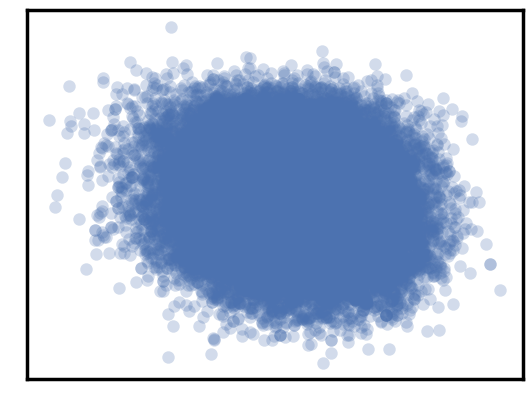

In [131]:
data=numpy.array(product_embeddings)
plt.scatter(data.T[0], data.T[1], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

AttributeError: 'KMeans' object has no attribute '__name__'

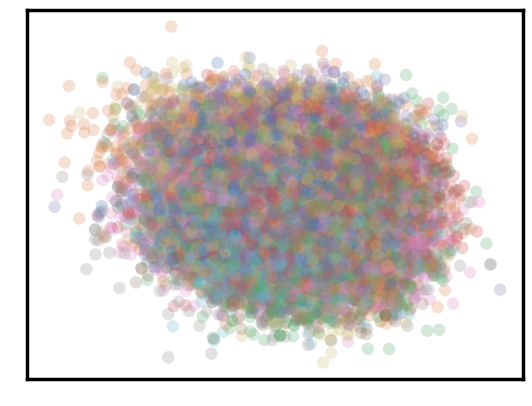

In [133]:
#new stuff Trey just moved here:
def plot_clusters(data, algorithm, args, kwds):
    #start_time = time.time()
    #labels = algorithm(*args, **kwds).fit_predict(data)
    #end_time = time.time()
    palette = sns.color_palette('deep', numpy.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    #return labels
    
plot_clusters(data, algo, (), {'n_clusters':10})

In [ ]:
#from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from itertools import cycle
import matplotlib.pyplot as plt
import matplotlib.cm as cm

n_clusters = 4
X, y_true = make_blobs(n_samples=300, centers=n_clusters,
                       cluster_std=0.60, random_state=0)
#kmeans = KMeans(n_clusters=n_clusters)
#kmeans.fit(X)
#y_kmeans = kmeans.predict(X)
#centers = kmeans.cluster_centers_

# map predictions to label
labels = {0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4"}

colors = cycle(cm.tab10.colors)
plt.figure()

for i in range(n_clusters):
    # plot one cluster for each iteration
    color = next(colors)
    # find indeces corresponding to cluser i
    idx = y_kmeans == i
    # plot cluster
    plt.scatter(X[idx, 0], X[idx, 1], color=color, s=50, label=labels[i], alpha=0.25)
    # plot center
    plt.scatter(centers[i, 0], centers[i, 1], edgecolors="k", linewidth=2, color=color, s=200, alpha=1)
plt.legend()

In [18]:
import pandas 

### Create Pandas dataframs for product_clusters
product_ids_labels= dict(zip(product_ids, labels))
print(type(product_ids_labels))
pddf_product_ids_labes=pandas.DataFrame.from_dict(product_ids_labels,orient='index',columns=['label'])
pddf_product_ids_labes['pid']=pddf_product_ids_labes.index
pddf_product_ids_labes

<class 'dict'>


,label,pid
793795300225,21,793795300225
25192147623,78,25192147623
883717008824,70,883717008824
008811194420,83,008811194420
016861895624,85,016861895624
...,...,...
056035361548,65,056035361548
097360309041,97,097360309041
43396129184,39,43396129184
086429215300,29,086429215300


In [19]:
idx_p=product_ids.index('718037753072')

idx_p,labels[idx_p] ,product_names[idx_p],product_ids[idx_p]

(56844,
 87,
 'Western Digital - Scorpio Blue 250GB Internal Serial ATA Hard Drive for Laptops',
 '718037753072')

In [20]:
#clusters[28]

In [40]:
### Get the cluster for the query based on prediction of the label
def get_query_cluster(query):
    q_emb = transformer.encode([query], convert_to_tensor=False)
    q_label=algo.predict(q_emb)
    return q_label


#query="'Western Digital - Scorpio Blue 250GB Internal Serial ATA Hard Drive for Laptops Serial ATA interface; quiet performance; 1.5GB/sec data transfer rate'"
#query=" 'Western Digital - Scorpio Blue 250GB Internal Serial ATA Hard Drive for Laptops'"
query="microwave"
l=get_query_cluster(query)
print(l)



[2]


In [41]:
import sentence_transformers
import pandas 
import heapq
#res = [test_list.index(i) for i in heapq.nlargest(N, test_list)]
## get the top n clusters based on similairty with centers 
def get_top_labels_centers(query,centers ,N=2):
    print(query)
    q_emb = transformer.encode([query], convert_to_tensor=False)
    similarities = sentence_transformers.util.cos_sim(q_emb, centers)
    sim=similarities.tolist()[0]
    res = [sim.index(i) for i in heapq.nlargest(N, sim)]
    return res
#query="Western Digital - Scorpio Blue 250GB Internal Serial ATA Hard Drive for Laptops Serial ATA interface; quiet performance; 1.5GB/sec data transfer rate"
query="microwave"
res=get_top_labels_centers(query,centers,N=5)


microwave


In [42]:
print(res)
#print(sim.index(max(sim))) ,sim

[2, 35, 62, 34, 60]


In [32]:
sdf_id_labeles=spark.createDataFrame(pddf_product_ids_labes).createOrReplaceTempView('products_clusters')


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [43]:
# Load signal data to create user-product vectors 
signals_collection="signals"
signals_opts={"zkhost": "aips-zk", "collection": signals_collection}
df_signals = spark.read.format("solr").options(**signals_opts).load()
df_signals.createOrReplaceTempView("signals")


In [44]:
#Create User-proudct data set for personalization
spark.sql("""
select  distinct user, target as product_id , name  as product_name
from signals s join products_samples p on s.target=p.upc
""").createOrReplaceTempView("user_product")

df_user_p=spark.sql("""select user,product_id, product_name,label from user_product a join 
products_clusters b on a.product_id = b.pid """).createOrReplaceTempView("user_product_label")

#rows=df_user_p.collect()




In [45]:
#spark.sql("select * from user_product_label limit 2 ").show()

spark.sql(" select * from user_product_label where lower(product_name) like '%microwave%' ").show(20)

## micro u638433 |u638433|751492508542|PNY - 2GB microSD...|   23|
## micro u514573|036725560406|Samsung - 1.7 Cu...

+-------+------------+--------------------+-----+
|   user|  product_id|        product_name|label|
+-------+------------+--------------------+-----+
|u185401|074000612624|Sharp - 0.8 Cu. F...|    2|
|u639817|074000612624|Sharp - 0.8 Cu. F...|    2|
| u62612|074000612624|Sharp - 0.8 Cu. F...|    2|
|u684071|084157186220|Daewoo - Touch Co...|    2|
|u517772|084157186220|Daewoo - Touch Co...|    2|
|u282231|048231316187|LG - 1.6 Cu. Ft. ...|    2|
|u182234|048231316187|LG - 1.6 Cu. Ft. ...|    2|
|u718867|048231316170|LG - 1.6 Cu. Ft. ...|    2|
|u719224|883049158211|Whirlpool - 2.0 C...|    2|
|u700867|084691224365|GE - 0.7 Cu. Ft. ...|    2|
|u549702|084691224365|GE - 0.7 Cu. Ft. ...|    2|
|u684841|084691208068|GE - 0.7 Cu. Ft. ...|    2|
|u452146|084691208068|GE - 0.7 Cu. Ft. ...|    2|
|u576996|084691208068|GE - 0.7 Cu. Ft. ...|    2|
|u317852|084691208068|GE - 0.7 Cu. Ft. ...|    2|
|u716615|084691208068|GE - 0.7 Cu. Ft. ...|    2|
|u122855|084691208068|GE - 0.7 Cu. Ft. ...|    2|


In [46]:
###### Personalized search approach 
# 1- given the query , get the top N clsuters for this query


query="microwave"

#query="'Western Digital - Scorpio Blue 250GB Internal Serial ATA Hard Drive for Laptops Serial ATA interface; quiet performance; 1.5GB/sec data transfer rate'"
query_clusters=get_top_labels_centers(query,centers,N=2)
print("query_clusters",query_clusters)

qcluster= ','.join(str (q) for q in query_clusters)
# 2- Given the user, find the elements he interacted with within this query clusters
user='u514573'
user_product_query = " select * from user_product_label where user = '" + user  + "' " + " and  label in (" + qcluster+ " )"

print(user_product_query)
user_items=spark.sql(user_product_query)#.show(10)

user_items.head()


microwave
query_clusters [2, 35]
 select * from user_product_label where user = 'u514573'  and  label in (2,35 )


Row(user='u514573', product_id='036725560406', product_name='Samsung - 1.7 Cu. Ft. Over-the-Range Microwave - Black', label=2)

In [47]:
# 3-Get All emb vectors for the user product  and create the user vector ( for now just avg)


product_ids_u=user_items.select('product_id').collect()

avg=None
for p in product_ids_u:
    
    print(p)
    if avg is None:
        avg = product_ids_emb[p[0]]
    else:
         avg= (avg+ product_ids_emb[p[0]]) /2

print(avg)
    

Row(product_id='036725560406')
[-9.44319740e-03 -6.52701035e-02 -1.34956939e-02 -2.14545988e-02
 -5.98770119e-02 -1.42378844e-02 -5.19651081e-03 -9.71718598e-03
 -2.83798538e-02  1.41727589e-02  5.09610400e-03  2.85506900e-02
 -2.08095964e-02  4.21384051e-02 -3.41786747e-03  1.08373113e-01
  2.92089139e-03  9.63064004e-03  2.49510892e-02 -1.58963669e-02
 -5.79855405e-02  2.23972537e-02  7.03050150e-03 -3.40860672e-02
 -2.07883064e-02  1.95801854e-02  6.41680649e-03 -3.64200808e-02
 -8.86633061e-03 -2.61159819e-02 -3.12964916e-02  3.19175981e-02
 -7.48751089e-02  2.49883235e-02  1.58364310e-06 -7.75170252e-02
  3.24130170e-02  6.49999885e-04 -2.83145458e-02 -2.83593461e-02
  6.75219893e-02  3.07300854e-02 -9.26550291e-03  1.43866567e-02
 -6.03652885e-03 -3.12762111e-02  3.08148731e-02  7.41422623e-02
 -6.70519695e-02 -4.02895361e-02  1.73798557e-02 -5.36329187e-02
 -4.51185799e-04  7.86301028e-03  1.89712550e-02 -3.40750511e-03
 -1.47183565e-03  5.16033312e-03  2.49691736e-02  7.2394967

In [48]:
# 4- Get all items for the search query using solr index
## Get the top items from the query cluster for the user
### User search query using solr 
import sys
sys.path.append('../..')
from aips import *
#query="Western Digital - Scorpio Blue 250GB Internal Serial ATA Hard Drive for Laptops Serial ATA interface; quiet performance; 1.5GB/sec data transfer rate"

query="microwave"
collection = "products"
request = {
    "query": query,
    "fields": ["upc", "name", "manufacturer", "score"],
    "limit": 10,
    "params": {
      "qf": "name manufacturer long_description",
      "defType": "edismax",
      "sort": "score desc, upc asc"
    }
}

search_results = requests.post(f"{SOLR_URL}/{collection}/select", json=request).json()["response"]["docs"]
print(search_results)
display(HTML(render_search_results(query, search_results)))


[{'upc': '048231317436', 'name': 'LG - Trim Kit for Select LG Microwave Ovens - Stainless-Steel', 'manufacturer': 'LG', 'score': 3.4165711}, {'upc': '084691211174', 'name': 'GE - Profile Advantium 1.7 Cu. Ft. Over-the-Range Microwave - Stainless-Steel/Black', 'manufacturer': 'GE', 'score': 3.4165711}, {'upc': '48231317436', 'name': 'LG - Trim Kit for Select LG Microwave Ovens - Stainless-Steel', 'manufacturer': 'LG', 'score': 3.4165711}, {'upc': '84691211174', 'name': 'GE - Profile Advantium 1.7 Cu. Ft. Over-the-Range Microwave - Stainless-Steel/Black', 'manufacturer': 'GE', 'score': 3.4165711}, {'upc': '048231317498', 'name': 'LG - 1.7 Cu. Ft. Over-the-Range Microwave - Stainless-Steel', 'manufacturer': 'LG', 'score': 3.3787842}, {'upc': '48231317498', 'name': 'LG - 1.7 Cu. Ft. Over-the-Range Microwave - Stainless-Steel', 'manufacturer': 'LG', 'score': 3.3787842}, {'upc': '037988910427', 'name': 'Panasonic - NNCD989S Microwave Oven - Stainless-Steel', 'manufacturer': 'Panasonic', 'sco

In [49]:
## 5- Rank all the results based on the user vector 

# []

from operator import itemgetter

# This to solve "0" issues on beginging of productID, should be removed later 
#solr_res_emb=[ product_ids_emb[search_results[x]['upc'][1:]]  if search_results[x]['upc'][0]=='0'else  product_ids_emb[search_results[x]['upc']] for x in range(len(search_results))]

solr_res_emb=[ product_ids_emb[search_results[x]['upc']] for x in range(len(search_results))]

len(solr_res_emb)


similarities = sentence_transformers.util.cos_sim(avg, solr_res_emb)

sim=similarities.tolist()[0]

print(sim)

res = [sim.index(i) for i in heapq.nlargest(len(sim), sim)]
print(res)

res, values = zip(*sorted(enumerate(sim), key=itemgetter(1),reverse=True))

print(res)

pres_res= [search_results[i] for i in res]
### Print original search query
#print(search_results)

print(pres_res)
#display(HTML(render_search_results(query, search_results)))

display(HTML(render_search_results(query, pres_res)))





[0.5939799547195435, 0.7581617832183838, 0.5939799547195435, 0.758161723613739, 0.8021668195724487, 0.8021668195724487, 0.6961016654968262, 0.6961016654968262, 0.8397796154022217, 0.8397796154022217]
[8, 8, 4, 4, 1, 3, 6, 6, 0, 0]
(8, 9, 4, 5, 1, 3, 6, 7, 0, 2)
[{'upc': '084691170679', 'name': 'GE - 1.1 Cu. Ft. Mid-Size Microwave - Black', 'manufacturer': 'GE', 'score': 3.2356415}, {'upc': '84691170679', 'name': 'GE - 1.1 Cu. Ft. Mid-Size Microwave - Black', 'manufacturer': 'GE', 'score': 3.2356415}, {'upc': '048231317498', 'name': 'LG - 1.7 Cu. Ft. Over-the-Range Microwave - Stainless-Steel', 'manufacturer': 'LG', 'score': 3.3787842}, {'upc': '48231317498', 'name': 'LG - 1.7 Cu. Ft. Over-the-Range Microwave - Stainless-Steel', 'manufacturer': 'LG', 'score': 3.3787842}, {'upc': '084691211174', 'name': 'GE - Profile Advantium 1.7 Cu. Ft. Over-the-Range Microwave - Stainless-Steel/Black', 'manufacturer': 'GE', 'score': 3.4165711}, {'upc': '84691211174', 'name': 'GE - Profile Advantium 1.

/opt/conda/lib/python3.10/site-packages/sentence_transformers/util.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  b = torch.tensor(b)


In [50]:
product_ids_emb['012505525582'] 

array([-2.92428564e-02, -2.85786693e-03, -9.31113493e-03, -7.40041882e-02,
       -2.09076386e-02, -1.58892199e-02,  1.08079938e-03, -1.99286006e-02,
        5.67965731e-02,  1.16581852e-02,  1.25303585e-02,  6.35479838e-02,
        6.51222914e-02,  9.62973163e-02, -5.48899127e-03, -5.16000343e-03,
       -3.15998085e-02,  1.83874816e-02,  2.78371628e-02,  3.02558357e-04,
        2.27561519e-02, -2.16201562e-02,  3.21825072e-02, -5.28684771e-03,
        4.12731282e-02,  2.24583466e-02,  5.84413251e-03,  1.26304766e-02,
       -8.26167990e-04, -1.12224802e-01,  5.20463195e-03,  8.01560581e-02,
       -3.21371071e-02,  4.53695320e-02,  1.10673261e-06, -3.96309495e-02,
        1.87677853e-02, -1.07242987e-02, -3.35063748e-02,  2.13071853e-02,
       -7.36522079e-02, -8.51790830e-02,  1.18251676e-02,  1.02426792e-02,
       -4.08365997e-03,  8.32238272e-02, -2.23729396e-04,  2.71663833e-02,
       -1.89157650e-02, -3.33056562e-02,  2.27626333e-05, -2.41718031e-02,
        6.20546602e-02, -

In [51]:
#clusters[70]

In [52]:
spark.sql("""select * from products where  upc=012505525582   """).show(20) # where product_id=084691208068 lower(name) like '%mircowave%


+--------------------+--------------------+------------+--------------------+--------------------+------------+
|                  id|     long_description|manufacturer|                name|    short_description|         upc|
+--------------------+--------------------+------------+--------------------+--------------------+------------+
|17d07583-8192-42f...|Stainless steel w...|Smart Choice|Smart Choice - St...|6 ft. Stainless S...| 12505525582|
|0894a881-371b-4de...|Stainless steel w...|Smart Choice|Smart Choice - St...|6 ft. Stainless S...|012505525582|
+--------------------+--------------------+------------+--------------------+--------------------+------------+



In [53]:
spark.sql("""select * from products_samples where  upc=084691208068   """).show(1) # where product_id=084691208068 lower(name) like '%mircowave%


+--------------------+------------+--------------------+--------------------+
|                name|         upc|    short_description|           name_desc|
+--------------------+------------+--------------------+--------------------+
|GE - 0.7 Cu. Ft. ...|084691208068|10 power levels; ...|GE - 0.7 Cu. Ft. ...|
+--------------------+------------+--------------------+--------------------+
only showing top 1 row



In [54]:
spark.sql("""select * from user_product where product_id=84691208068 """).show(10) # where product_id=084691208068 lower(name) like '%mircowave%


+-------+------------+--------------------+
|   user|  product_id|        product_name|
+-------+------------+--------------------+
|u684841|084691208068|GE - 0.7 Cu. Ft. ...|
|u452146|084691208068|GE - 0.7 Cu. Ft. ...|
|u576996|084691208068|GE - 0.7 Cu. Ft. ...|
|u317852|084691208068|GE - 0.7 Cu. Ft. ...|
|u716615|084691208068|GE - 0.7 Cu. Ft. ...|
|u122855|084691208068|GE - 0.7 Cu. Ft. ...|
|u532651|084691208068|GE - 0.7 Cu. Ft. ...|
| u25776|084691208068|GE - 0.7 Cu. Ft. ...|
| u12589|084691208068|GE - 0.7 Cu. Ft. ...|
|u372905|084691208068|GE - 0.7 Cu. Ft. ...|
+-------+------------+--------------------+
only showing top 10 rows



In [55]:
spark.sql("""select * from user_product where user = 'u254574' """).show(10) # where product_id=084691208068 lower(name) like '%mircowave%


+-------+------------+--------------------+
|   user|  product_id|        product_name|
+-------+------------+--------------------+
|u254574|084691208068|GE - 0.7 Cu. Ft. ...|
+-------+------------+--------------------+



In [56]:
spark.sql("""
select  *
from signals s join products_samples p  on target=upc where upc=084691208068 and target=084691208068
""").show(2)


+--------------------+-----------+--------------------+------------+-----------+-------+--------------------+------------+--------------------+--------------------+
|                  id|   query_id|         signal_time|      target|       type|   user|                name|         upc|    short_description|           name_desc|
+--------------------+-----------+--------------------+------------+-----------+-------+--------------------+------------+--------------------+--------------------+
|229bd040-c43d-4ea...|u684841_1_2|2020-04-10 04:44:...|084691208068|add-to-cart|u684841|GE - 0.7 Cu. Ft. ...|084691208068|10 power levels; ...|GE - 0.7 Cu. Ft. ...|
|4615d200-f05c-478...|u452146_4_8|2020-05-07 10:09:...|084691208068|      click|u452146|GE - 0.7 Cu. Ft. ...|084691208068|10 power levels; ...|GE - 0.7 Cu. Ft. ...|
+--------------------+-----------+--------------------+------------+-----------+-------+--------------------+------------+--------------------+--------------------+
only show

In [47]:
#####################OLD FAISS and other index to be removed

In [48]:
##FAISS INDEX
### Build the vector index  Using FAISS
d=len(product_embeddings[0])
index = faiss.IndexFlatL2(d)   # build the index

#xb = numpy.random.random((len(product_embeddings), d)).astype('float32')
xb=numpy.array(product_embeddings)
print(xb.shape)
print(index.is_trained)
index.add(xb)                  # add vectors to the index
print("index.ntotal", index.ntotal)


(68421, 768)
True
index.ntotal 68421


In [49]:
#### Test the index 
k = 2                          # we want to see 4 nearest neighbors
qk= 3 ## check for first qk vetcore

D, I = index.search(xb[:qk], k) # sanity check
'''
print("I", I ,type(I),I[0][0])
print("len-p-names",len(product_names))
print("len-p-names",len(xb))
print("shape xp",xb.shape)
'''

for n in range(qk):
    print( "Q:  ",product_names[n])
    for i in range(k):
        #print("i, n, k,  I[n][i] , I[n]",i,n,k, I[n][i],I[n] )
        #print( " Q Names ",product_names[n], "----> I name", product_names[int(I[n][i])], " ---> I id ",product_ids[int(I[n][i])] )
        print( "----> Res:" , i ,  product_names[int(I[n][i])], ",  id: ",product_ids[int(I[n][i])] )

Q:   Sanus - Ultimate Foundations 22" Speaker Stands (Pair)
----> Res: 0 Sanus - Ultimate Foundations 22" Speaker Stands (Pair) ,  id:  793795300225
----> Res: 1 Sanus - Natural 18" Speaker Stands (Pair) ,  id:  793795281814
Q:   Dr Seuss The Cat In The Hat (2003) - (Ws Dub Sub) - DVD
----> Res: 0 Dr Seuss The Cat In The Hat (2003) - (Ws Dub Sub) - DVD ,  id:  25192147623
----> Res: 1 Dr Seuss The Cat In The Hat (2003) - (Ws Dub Sub) - DVD ,  id:  025192147623
Q:   Baby Face - CD
----> Res: 0 Baby Face - CD ,  id:  883717008824
----> Res: 1 Baby Geniuses - CD ,  id:  788037060128


In [50]:
### find product based on user vector  " FASISS"

#### seacrh for some vectors
k = 3                       # we want to see k nearest neighbors
qk= 1 ## check for first qk vetcore

print(user_emb[rows[1][0]].shape)
### Get user embedding vector.

uq=numpy.array([user_emb[rows[1][0]]])
### create vector 
print(uq.shape)

D, I = index.search(uq,k)
print("I", I ,type(I),I[0][0])
print("len-p-names",len(product_texts))
print("len-p-names",len(xb))
print("shape xp",xb.shape)

for n in range(qk):
    #print( "Q:  ",product_names[n])
    
    for i in range(k):
        
        #print("i, n, k,  I[n][i] , I[n]",i,n,k, I[n][i],I[n] )
        #print( " Q Names ",product_names[n], "----> I name", product_names[int(I[n][i])], " ---> I id ",product_ids[int(I[n][i])] )
        print( "----> Res:" , i ,  product_names[int(I[n][i])], ",  id: ",product_ids[int(I[n][i])] )
        
        
    print("User-- actual product interaction")
    
    query= "select * from  user_product where user = '" + str(rows[1][0]) + "'"
    print(query)
    spark.sql(query).show(10)

NameError: name 'user_emb' is not defined

In [51]:
#### check the normal query against product 
### and after personalize it using the user product 
#print(product_names)

q=[" 2GB microSD Memory Card "]
q=["Digital Camera "]
#q=['CD CD CD']
q_emb = .encode(q, convert_to_tensor=False)
#print(q_emb.shape)
#print(product_names.index("Watch The Throne (Bonus Tracks) (Deluxe Edition) - CD"))
#print(product_names[product_names.index("Watch The Throne (Bonus Tracks) (Deluxe Edition) - CD")])


In [52]:
#### check search query
k = 3                          # we want to see 4 nearest neighbors
qk= 1
#print(uq)
#print(q_embeddings)

D, I = index.search(q_emb,k)
print(D,I)
print(qk)
for n in range(qk):
    for i in range(k):
        print("int(I[n][i]",int(I[n][i]))
        print( "----> Res:" , i ,  product_names[int(I[n][i])], ",  id: ",product_ids[int(I[n][i])] )
        
        


[[0.60077155 0.60077155 0.6767436 ]] [[14917 47490 32222]]
1
int(I[n][i] 14917
----> Res: 0 Sony - Cyber-shot 16.2-Megapixel Digital Camera ,  id:  027242808676
int(I[n][i] 47490
----> Res: 1 Sony - Cyber-shot 16.2-Megapixel Digital Camera ,  id:  27242808676
int(I[n][i] 32222
----> Res: 2 Sony - Cyber-shot 16.1-Megapixel Zoom Digital Camera - Silver ,  id:  27242808621


In [53]:
### PERSONALIZATION

uq=numpy.array([user_emb[rows[1][0]]])
avg_q= (uq + q_emb ) /2

k = 5                          # we want to see 4 nearest neighbors
qk= 1
#print(uq)
#print(q_embeddings)
print(" Use the original query")
D, I = index.search(q_emb,k)
print(D,I)
for n in range(qk):
    for i in range(k):
        print( "----> Res:" , i ,  product_names[int(I[n][i])], ",  id: ",product_ids[int(I[n][i])] )
        
print(" Use the personalize query  Queryvector + User vector")

D, I = index.search(avg_q,k)
print(D,I)
for n in range(qk):
    for i in range(k):
        print( "----> Res:" , i ,  product_names[int(I[n][i])], ",  id: ",product_ids[int(I[n][i])] )
      


NameError: name 'user_emb' is not defined

In [54]:
#### USING NMSLIB instead of FAISS

import nmslib
# initialize a new index, using a HNSW index on Cosine Similarity
nmsIndex = nmslib.init(method='hnsw', space='cosinesimil')
nmsIndex.addDataPointBatch(product_embeddings)
nmsIndex.createIndex(print_progress=True)

# Example query for the new index.  The 25th embedding is the term 'bag'
ids, distances = nmsIndex.knnQuery(q_emb, k=2)
matches = [product_names[idx] for idx in ids]
print(matches)

['Sony - Cyber-shot 16.2-Megapixel Digital Camera', 'Sony - Cyber-shot 16.2-Megapixel Digital Camera']


In [55]:
q=[" 2GB microSD Memory Card "]
q=['Digital camera']
q_emb = .encode(q, convert_to_tensor=False)


## PERSONALIZATION

uq=numpy.array([user_emb[rows[1][0]]])

avg_q= ((0.5*uq) + 1.5*q_emb )/2
avg_q= ((1*uq) + 1*q_emb )/2

k =5                          # we want to see 4 nearest neighbors
qk= 1
#print(uq)
#print(q_embeddings)
print(" Use the original query: Query vector")
I,D = nmsIndex.knnQuery(q_emb, k)
print(D,I)

for i in I:
    print( "----> Res:" , i ,  product_names[i], ",  id: ",product_ids[i] )
        
print(" Use the personalization query:  Query vector + User vector")

I, D = nmsIndex.knnQuery(avg_q,k)
print(D,I)
for i in range(k):
        print( "----> Res:" , i ,  product_names[int(I[i])], ",  id: ",product_ids[int(I[i])] )
      


NameError: name 'user_emb' is not defined

In [ ]:
### Second approach, use the user vector to rank the results
import sentence_transformers
import pandas

#Find simialrity score between the queries and results

similarities = sentence_transformers.util.cos_sim(uq, product_embeddings[I])

similarities=similarities.tolist()
print(similarities)
a_phrases = []
b_phrases = []
scores = []
for a in range(len(similarities)):
    for b in range(a, len(similarities[a])):
        a_phrases.append(product_names[I[a]])
        b_phrases.append(product_names[I[b]])
        scores.append(float(similarities[a][b]))
print(scores)        
comparisons = pandas.DataFrame({"Query":a_phrases,"Result":b_phrases,"score":scores,"name":"similarity"})
comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
comparisons["idx"] = range(len(comparisons))
comparisons[comparisons["score"]>0 ]


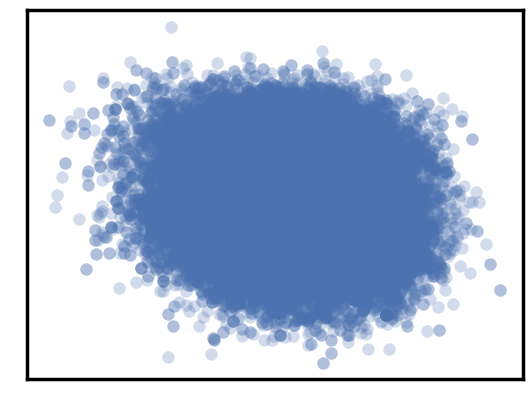

In [56]:
data=numpy.array(product_embeddings)
plt.scatter(data.T[0], data.T[1], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

In [57]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', numpy.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    return labels

In [58]:
def get_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    algo=algorithm(*args, **kwds).fit(data)
    labels = algo.predict(data)
    end_time = time.time()
    return algo, labels,algo.cluster_centers_

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [59]:
x=[len(clusters[i]) for i in clusters]
len(centers)

100

In [60]:
aq_emb1 = .encode(["Lumix S3 14.1-Megapixel Digital Camera - Black"], convert_to_tensor=False)

def cast_vector(row):
    return numpy.array(list(map(lambda x: x.astype('double'), row)))
#a=cast_vector(q_emb1)

a = numpy.array(q_emb1, dtype=numpy.double)

print(type(q_emb1),q_emb1.dtype)

l=algo.predict(q_emb1)
print(l)
#print(clusters[27])

NameError: name 'q_emb1' is not defined

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


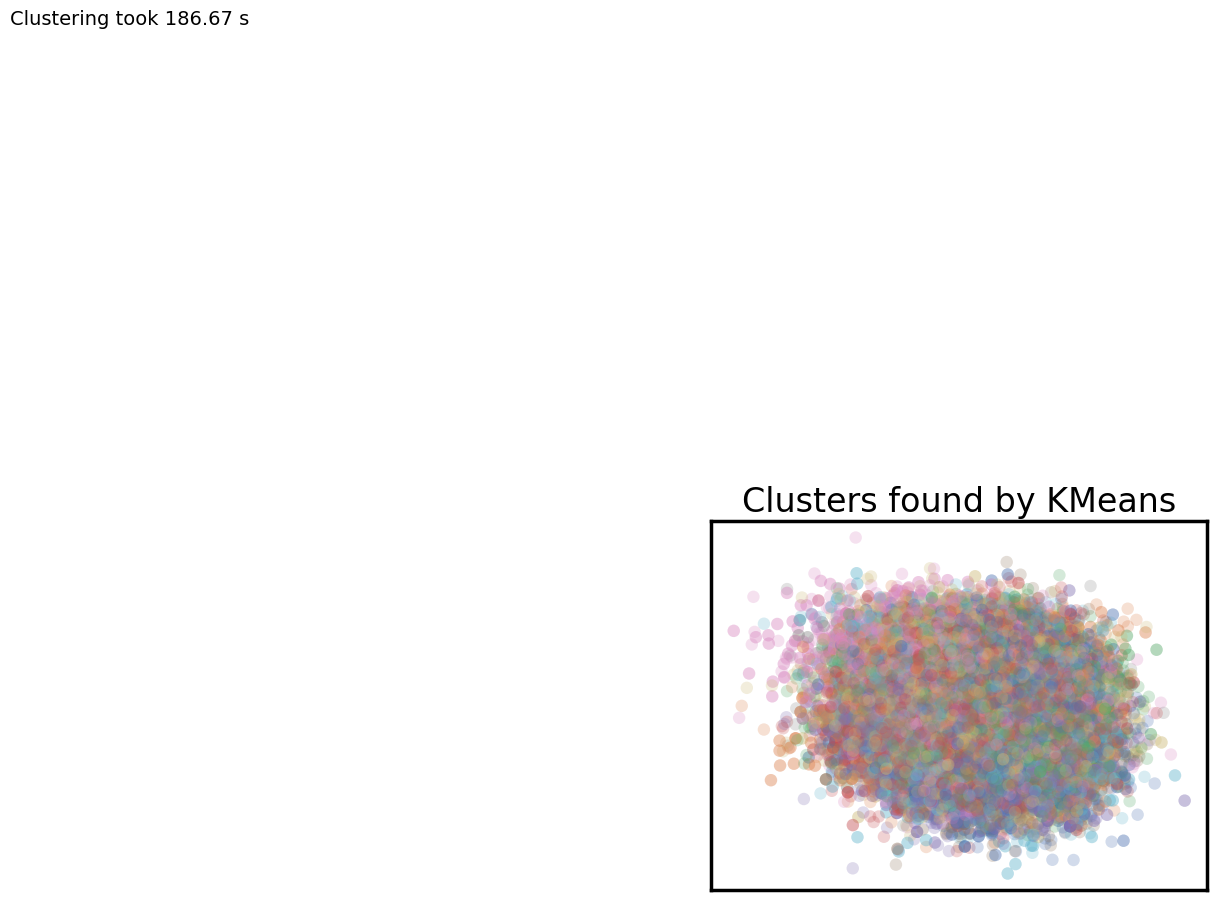

In [61]:
labels=plot_clusters(data, cluster.KMeans, (), {'n_clusters':100})


In [62]:
labels

array([ 9, 10, 34, ...,  6, 47, 53], dtype=int32)

In [ ]:
plot_clusters(data, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})


In [74]:
from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [171]:
last_hidden_states = output.last_hidden_state
arr=last_hidden_states.detach().numpy()


1


AuthenticationError: No API key provided. You can set your API key in code using 'openai.api_key = <API-KEY>', or you can set the environment variable OPENAI_API_KEY=<API-KEY>). If your API key is stored in a file, you can point the openai module at it with 'openai.api_key_path = <PATH>'. You can generate API keys in the OpenAI web interface. See https://onboard.openai.com for details, or email support@openai.com if you have any questions.

In [143]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.sql.functions import col, explode

signals_collection = "signals"

# Load signals from Solr
signals_read_opts = {"zkhost": "aips-zk", "collection": signals_collection}
sql_filter = """select user, target, type
from signals
where user is not null and type='click'
"""
signals_df = spark.read.format("solr").options(**signals_read_opts).load()
signals_df.registerTempTable("signals")
signals_df = spark.sql(sql_filter)

# Encode 'user' and 'target' fields into integer IDs
indexer_user = StringIndexer(inputCol="user", outputCol="userId")
indexer_target = StringIndexer(inputCol="target", outputCol="itemId")

In [144]:
index_model_user = indexer_user.fit(signals_df)
index_model_target = indexer_target.fit(signals_df)
signals_df = index_model_user.transform(signals_df)
signals_df = index_model_target.transform(signals_df)

# Prepare data for ALS model
data = signals_df.select(col("userId").cast("int"), 
                         col("itemId").cast("int"), 
                         col("type").cast("int"))

# Split the data into training and test sets
(training, test) = data.randomSplit([0.8, 0.2])



In [133]:
# Initialize ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="itemId", ratingCol="type", coldStartStrategy="drop")

In [145]:
# Train ALS model
model = als.fit(training)

Py4JJavaError: An error occurred while calling o484.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 57.0 failed 1 times, most recent failure: Lost task 0.0 in stage 57.0 (TID 199) (e4cddd0ffcb3 executor driver): java.lang.NullPointerException: Value at index 2 is null
	at org.apache.spark.sql.errors.QueryExecutionErrors$.valueIsNullError(QueryExecutionErrors.scala:1733)
	at org.apache.spark.sql.Row.getAnyValAs(Row.scala:527)
	at org.apache.spark.sql.Row.getFloat(Row.scala:263)
	at org.apache.spark.sql.Row.getFloat$(Row.scala:263)
	at org.apache.spark.sql.catalyst.expressions.GenericRow.getFloat(rows.scala:166)
	at org.apache.spark.ml.recommendation.ALS.$anonfun$fit$2(ALS.scala:713)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$SliceIterator.next(Iterator.scala:273)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at scala.collection.AbstractIterator.to(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$take$2(RDD.scala:1470)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2268)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.rdd.RDD.$anonfun$take$1(RDD.scala:1470)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1443)
	at org.apache.spark.rdd.RDD.$anonfun$isEmpty$1(RDD.scala:1578)
	at scala.runtime.java8.JFunction0$mcZ$sp.apply(JFunction0$mcZ$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.isEmpty(RDD.scala:1578)
	at org.apache.spark.ml.recommendation.ALS$.train(ALS.scala:960)
	at org.apache.spark.ml.recommendation.ALS.$anonfun$fit$1(ALS.scala:722)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.recommendation.ALS.fit(ALS.scala:704)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.NullPointerException: Value at index 2 is null
	at org.apache.spark.sql.errors.QueryExecutionErrors$.valueIsNullError(QueryExecutionErrors.scala:1733)
	at org.apache.spark.sql.Row.getAnyValAs(Row.scala:527)
	at org.apache.spark.sql.Row.getFloat(Row.scala:263)
	at org.apache.spark.sql.Row.getFloat$(Row.scala:263)
	at org.apache.spark.sql.catalyst.expressions.GenericRow.getFloat(rows.scala:166)
	at org.apache.spark.ml.recommendation.ALS.$anonfun$fit$2(ALS.scala:713)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$SliceIterator.next(Iterator.scala:273)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at scala.collection.AbstractIterator.to(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$take$2(RDD.scala:1470)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2268)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


In [ ]:
# Train ALS model
model = als.fit(training)

# Generate top 10 product recommendations for each user
userRecs = model.recommendForAllUsers(10)

# Mapping back the 'userId' and 'itemId' to original 'user' and 'target' values
user_to_string_indexer = IndexToString(inputCol="userId", outputCol="user", labels=index_model_user.labels)
item_to_string_indexer = IndexToString(inputCol="itemId", outputCol="target", labels=index_model_target.labels)

userRecs = user_to_string_indexer.transform(userRecs)

# To convert the recommendations from array format to multiple rows,
# we explode the recommendations array
userRecs = userRecs.withColumn("recommendations", explode(userRecs.recommendations))

userRecs = item_to_string_indexer.transform(userRecs)

# Display the recommendations
userRecs.select("user", "recommendations.target", "recommendations.rating").show()
